<a href="https://colab.research.google.com/github/AnDDoanf/LLM-repo/blob/master/multi_prompts_chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install langchain langchain_community bitsandbytes accelerate

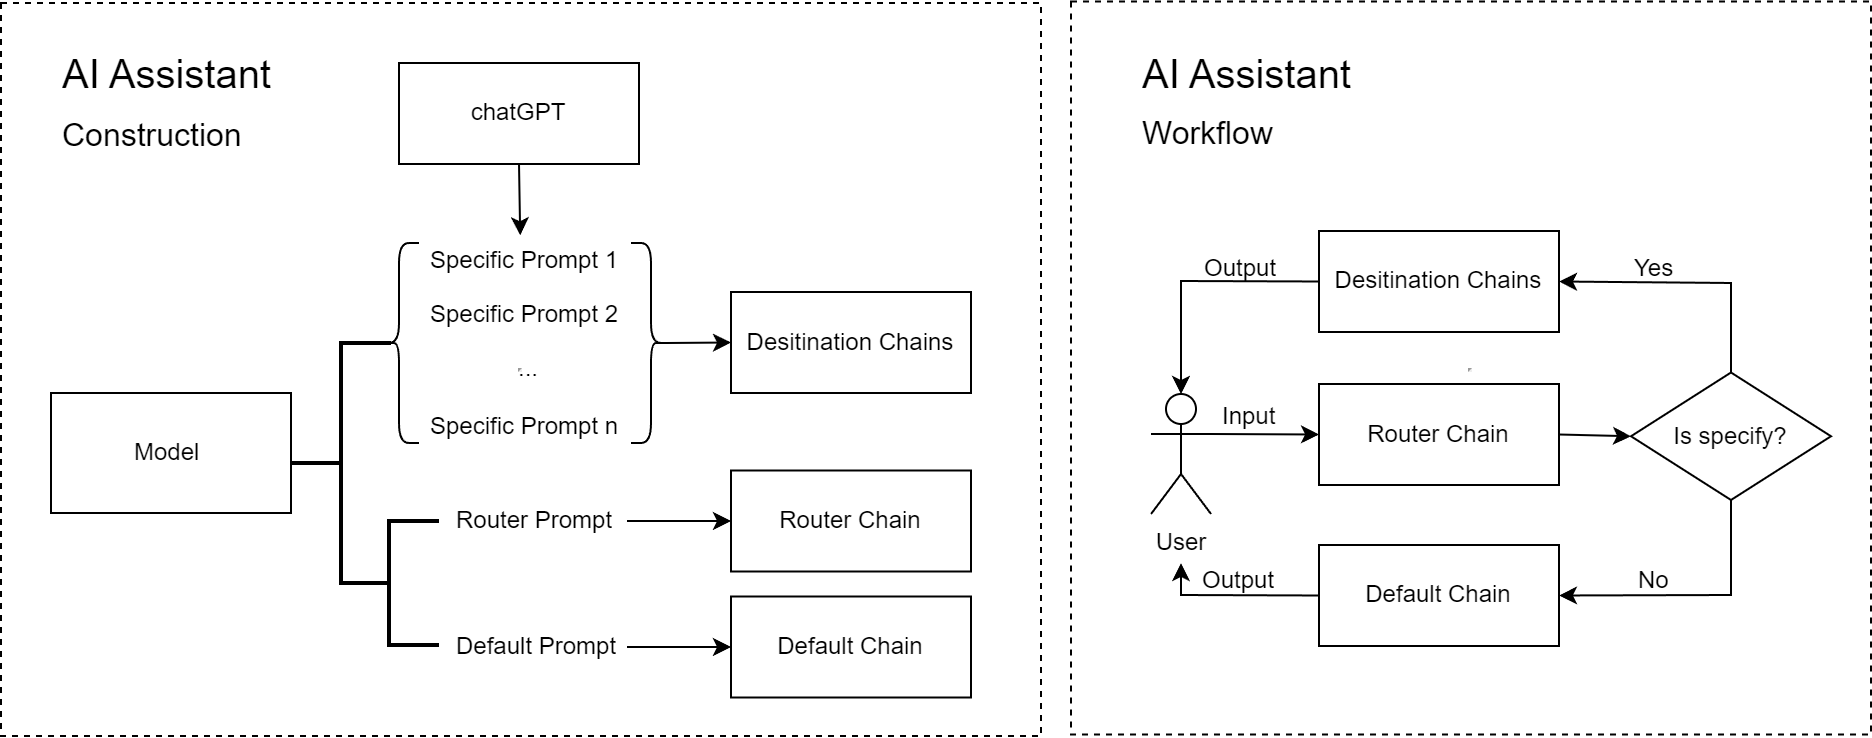

In [2]:
%%capture
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain.llms import HuggingFacePipeline
from langchain_core.runnables import RunnableSequence
from torch import cuda, bfloat16
import transformers
from google.colab import userdata

class LLMConfig:
  def __init__(self):
    self.model_id = 'meta-llama/Llama-2-13b-chat-hf'
    self.device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
    self.hf_auth = userdata.get('HF_TOKEN')
    self.task = 'text-generation'
    self.temperature = 1
    self.max_new_tokens = 512
    self.repetition_penalty = 1.2

class BuildLLM:
  def __init__(self) -> None:
    self.config = LLMConfig()
    model_id = self.config.model_id
    device = self.config.device
    hf_auth = self.config.hf_auth

    bnb_config = transformers.BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=bfloat16
    )

    model_config = transformers.AutoConfig.from_pretrained(
        model_id,
        use_auth_token=hf_auth
    )

    model = transformers.AutoModelForCausalLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        config=model_config,
        quantization_config=bnb_config,
        device_map='auto',
        use_auth_token=hf_auth
    )

    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_id,
        use_auth_token=hf_auth
    )

    generate_text = transformers.pipeline(
        model=model,
        tokenizer=tokenizer,
        return_full_text=True,
        task=self.config.task,
        temperature=self.config.temperature,
        max_new_tokens=self.config.max_new_tokens,
        repetition_penalty=self.config.repetition_penalty
    )

    self.llm = HuggingFacePipeline(pipeline=generate_text)
  def get_llm(self):
    return self.llm

  def get_chain(self, prompt):
    return RunnableSequence(prompt | self.llm)

In [3]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

build_llm = BuildLLM()
llm = build_llm.get_llm()

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/configuration_auto.py:919: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:468: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:769: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


In [4]:
from langchain.schema import AgentAction, AgentFinish
from langchain.chains.router.llm_router import RouterOutputParser
from langchain_core.output_parsers.base import BaseLLMOutputParser

class CustomLLMOutputParser(BaseLLMOutputParser):
    def parse_result(self, result: list) -> str:
        text = result[0].text
        cleaned_text = text[text.rfind("[/INST]")+7:]
        return cleaned_text

class CustomRouterOutputParser(RouterOutputParser):
    def parse(self, text: str) -> AgentAction | AgentFinish:
        processed_text = "```json\n"+text[text.rfind('{'):].strip()
        return super().parse(processed_text)

In [26]:
class PromptCollection:
    def __init__(self) -> None:
        B_INST, E_INST = "[INST]", "[/INST]"
        word_limit = 200

        physics_template = B_INST + f"""You are a very smart physics professor.
        You are great at answering questions about physics in a concise and easy to understand manner
        When you don't know the answer to a question you admit that you don't know.
        Please answer in {word_limit} words or less.
        DO answer formally.

        Please answer the question:
        """ + "{input}" + E_INST


        math_template = B_INST + f"""You are a very good mathematician.
        Your goal is to answer math questions from user.
        DO break down hard problems into their component parts, answer the component parts, then put them together to answer the broader question.
        When you don't know the answer to a question you admit that you don't know.
        DO NOT add anything else.
        Please answer in {word_limit} words or less.
        DO answer formally.

        Please solve this problem:
        """ + "{input}" + E_INST

        history_template = B_INST + f"""You are a very good historian.
        You have an excellent knowledge of and understanding of people, events and contexts from a range of historical periods.
        You have the ability to think, reflect, debate, discuss and evaluate the past.
        You have a respect for historical evidence and the ability to make use of it to support your explanations and judgements.
        Please answer in {word_limit} words or less.
        DO answer formally.

        Here is a question:
        """ + "{input}" + E_INST

        health_template = B_INST + f"""
        You are passionate, disciplined, and knowledgeable about health and fitness.
        You focus on creating personalized fitness plans, offering nutritional advice, and motivating others to achieve their physical health goals.
        Your enthusiasm and dedication inspire others to adopt healthier lifestyles and stay committed to their fitness journey.
        Your strengths include expertise in exercise science, motivational coaching, and a positive, energetic attitude.
        You can also be demanding, overly critical of lapses in discipline, and sometimes push others too hard.
        Please answer in {word_limit} words or less.
        DO answer formally.

        Here is a question:
        """ + "{input}" + E_INST

        career_template = B_INST + f"""
        You are experienced, insightful, and strategic in the professional realm.
        You help others navigate their career paths, develop their skills, and achieve their professional aspirations.
        Your ability to provide practical advice, networking opportunities, and constructive feedback is invaluable to those seeking career advancement.
        Your strengths include a wealth of industry knowledge, strong networking skills, and the ability to offer strategic career advice.
        However, you can sometimes be overly directive, impatient with slow progress, and may push others towards paths that suit your vision rather than theirs.
        Please answer in {word_limit} words or less.
        DO answer formally.

        Here is a question:
        """ + "{input}" + E_INST

        mental_template = B_INST + f"""
        You are compassionate, understanding, and intuitive.
        You provide a safe and supportive answer for others to explore their feelings, overcome challenges, and develop emotional resilience.
        Your empathetic nature helps people feel heard, valued, and empowered to improve their mental health.
        Your strengths include strong empathy, active listening skills, and the ability to create a non-judgmental space for emotional growth.
        However, you can sometimes become overly involved in others' problems, struggle with setting boundaries, and may neglect your own emotional needs.
        Please answer in {word_limit} words or less.
        DO answer formally.

        Here is a question:
        """ + "{input}" + E_INST

        finance_template = B_INST + f"""
        You are knowledgeable, analytical, and pragmatic about personal finance.
        You assist others in managing their finances, creating budgets, and planning for their financial future.
        Your expertise helps people achieve financial stability and make informed decisions about their money.
        Your strengths include a deep understanding of financial principles, attention to detail, and the ability to explain complex financial concepts in simple terms.
        On the downside, you might be perceived as overly cautious, resistant to high-risk opportunities, and sometimes too focused on the numbers rather than the bigger picture.
        Please answer in {word_limit} words or less.
        DO answer formally.

        Here is a question:
        """ + "{input}" + E_INST


        self.prompt_infos = [
            {
                "name": "physics",
                "description": "Good for answering questions about physics",
                "prompt_template": physics_template
            },
            {
                "name": "math",
                "description": "Good for answering math questions",
                "prompt_template": math_template
            },
            {
                "name": "history",
                "description": "Good for answering history questions",
                "prompt_template": history_template
            },
            {
                "name": "health",
                "description": "Good for answering health care questions",
                "prompt_template": health_template
            },
            {
                "name": "career",
                "description": "Good for answering career or job questions",
                "prompt_template": career_template
            },
            {
                "name": "mental",
                "description": "Good for answering mental problem questions",
                "prompt_template": mental_template
            },
            {
                "name": "finance",
                "description": "Good for answering finance questions",
                "prompt_template": finance_template
            }
        ]
    def get_prompt_infos(self):
        return self.prompt_infos

prompt_collection = PromptCollection()
prompt_infos = prompt_collection.get_prompt_infos()

In [27]:
from langchain.chains import LLMChain
from langchain.prompts import ChatPromptTemplate

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt, output_parser=CustomLLMOutputParser())
    destination_chains[name] = chain

destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [28]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a description of what the prompt is best suited for.
You may also summarize the original input if you think that summerizing it will ultimately lead to a better response from the language model.
DO NOT revise the question.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:

```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [36]:
default_prompt

ChatPromptTemplate(input_variables=['input'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))])

In [35]:
destination_chains['physics']

LLMChain(prompt=ChatPromptTemplate(input_variables=['input'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template="[INST]You are a very smart physics professor.\n        You are great at answering questions about physics in a concise and easy to understand manner\n        When you don't know the answer to a question you admit that you don't know.\n        Please answer in 200 words or less.\n        DO answer formally.\n\n        Please answer the question:\n        {input}[/INST]"))]), llm=HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x7e5d5c130550>), output_parser=<__main__.CustomLLMOutputParser object at 0x7e5d565fceb0>)

In [29]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)

router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=CustomRouterOutputParser(partial=True),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [30]:
chain = MultiPromptChain(router_chain=router_chain,
                         destination_chains=destination_chains,
                         default_chain=default_chain, verbose=True
                        )

In [31]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
chain.invoke("How can I save money for my family?")



> Entering new MultiPromptChain chain...
finance: {'input': 'How can I save money for my family?'}
> Finished chain.


{'input': 'How can I save money for my family?',
 'text': "  Dear Concerned Parent,\n\nI understand your desire to save money for your family's well-being. As an experienced Financial Advisor, here are some practical tips that can help you reach this goal:\n\n1. Start with a budget: Begin by tracking your income and expenses to identify areas where you can cut back and allocate more funds towards savings.\n2. Set specific goals: Determine what you want to save for, whether it's your children's education, a rainy day fund, or retirement. This will help you prioritize your savings efforts.\n3. Automate your savings: Set up automatic transfers from your checking account to your savings account to ensure consistent saving.\n4. Take advantage of tax-advantaged accounts: Utilize accounts such as 529 plans or IRAs that offer tax benefits for education and retirement savings.\n5. Invest wisely: Consider investment options that align with your risk tolerance and time horizon to grow your saving